In [1]:
from keras.datasets import boston_housing

Using TensorFlow backend.


In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
from keras import models, layers, metrics, optimizers, losses
import numpy as np
import matplotlib.pyplot as plt

In [4]:
print(train_data.shape, test_data.shape) 

(404, 13) (102, 13)


In [5]:
# We should input quantities of roughly the same order of magnitude
# Otherwise huge gradientrs may appear, prohibitng the network from reaching equilibrium
# We thus normalize the mean and std using training data

mean = train_data.mean(axis=0)

In [6]:
mean.shape

(13,)

In [7]:
train_data -= mean

In [8]:
std = train_data.std(axis=0)

In [9]:
train_data /= std

In [10]:
test_data -= mean
test_data /= std

In [11]:
# Typical dwelling price: 22 K USD (in the 1970s!)
train_targets.mean()

22.395049504950492

In [13]:
# This time we introduce model builder: automatic model instantiation for later use

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [14]:
# Due to the modest dataset power we shall use k-fold validation
# We also measure total evaluation time - this TF is compiled to use AVX, noticable speedup

import numpy as np
import time

start_time = time.time()

# We go with 4 folds: divide training set into 4 chunks and hold one for validation each time
k=4
num_val_samples = len(train_data)//k
num_epochs = 100

# A table for collecting scores over training period across all folds
all_scores = []

for i in range(k):
    print('Processing fold #', i)
    
    # Selecting validation chunk: 1 to 4 sequentially
    
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i*num_val_samples],
         train_data[(i+1)*num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
         train_targets[(i+1)*num_val_samples:]],
        axis=0)
    
    # Call for a (FRESH UNTRAINED!) model instance
    model = build_model()
    
    # Fit it with the current validation data and muted output
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    
    # We track Mean Absolute Error
    all_scores.append(val_mae)

print("--- %s seconds ---" % (time.time() - start_time))
    
    
    
    
    

Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3
--- 236.8699505329132 seconds ---


In [13]:
# The scores across folds, should be of roughly same order
all_scores

[1.9579875126923665, 2.1724440083645358, 3.0232534361357737, 2.268872288194033]

In [14]:
# The final score: mean over folds
np.mean(all_scores)

2.3556393113466774

In [15]:
# Let us train the model significanlty longer (more epochs) 
# We also track detailed information about the validation score dynamics 

import numpy as np

start_time = time.time()
k=4
num_val_samples = len(train_data)//k
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('Processing fold #', i)
    
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i*num_val_samples],
         train_data[(i+1)*num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
         train_targets[(i+1)*num_val_samples:]],
        axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
              validation_data=(val_data, val_targets),
              epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    
print(" ----- %s seconds -----" % (start_time - time.time()))    

Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3
 ----- -1514.9250147342682 seconds -----


In [16]:
# How many minutes?
1514%60

14

In [21]:
# We get four MAE histories, for each fold
np.asarray(all_mae_histories).shape

(4, 500)

In [22]:
# Averaging over MAE histories to get single validation score dynamics
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

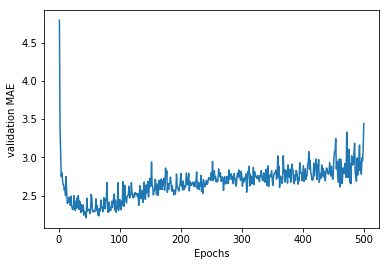

In [23]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('validation MAE')
plt.show()

In [15]:
# There is clearly a minimum, at which we should stop training to avoid overfitting
# To pinpoint it we can use popular moving exponent average smoothing filter

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


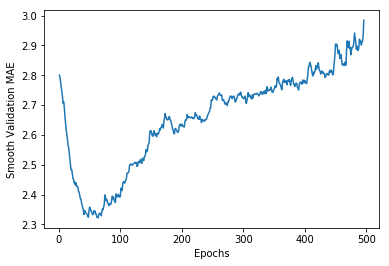

In [27]:
# Smoothing the histories
smooth_mae_history = smooth_curve(average_mae_history[4:])

plt.plot(range(1,len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Smooth Validation MAE')
plt.show()

In [33]:
# Training to the best epochs count before overfitting: hyperparameter tuned on validation set

start_time = time.time()

model = build_model()
model.fit(train_data, train_targets, 
         epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print(" ----- %s seconds -----" % (time.time() - start_time))

102/102 [==============================] - 0s 1ms/step
 ----- 5.504823207855225 seconds -----


In [35]:
# The ultimate score of the model: still 2.5 K USD off!
test_mae_score

2.5593712844100653